In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter1d

## Load depth image

In [ ]:

def load_depth_image(npz_path):
    # Load the npz file and extract the depth image
    height_data = np.load(npz_path)
    height_data = next(iter(height_data.values()))
    height_data = height_data.reshape((256, 256))-42

    # Display
    plt.imshow(height_data, cmap='gray')
    plt.axis('off')  # Hide axis for better visualization
    plt.title("Depth/Height")
    plt.show()
    return height_data


## Create panorama

height_data: A 2D array representing height values at each point in the terrain or structure.

fov: Field of view (assume panorama is complete, fox is set to 360 by default).

rotation: The initial rotation angle for the panorama generation.

height_scale: A scaling factor applied to the heights in the data.

Assumptions:
- assume the camera position is the center of the image


In [ ]:
def create_panorama_poc(height_data, fov=360, rotation=0, height_scale=1.0, sky_space = 10):

    map_height, map_width = height_data.shape
    # camera_position = (map_width // 2, map_height // 2) # Assume center point
    camera_position = (80,50)
    output_width = fov  # Each degree in the panorama
    max_height = int(np.max(height_data) * height_scale)
    panorama = np.zeros((max_height+sky_space, output_width), dtype=np.uint8)  # Black-and-white panorama

    # Normalize height data to grayscale (0-255)
    normalized_heights = (height_data / np.max(height_data) * 255).astype(np.uint8)

    # Loop over each degree in the panorama (360 degrees)
    for angle in range(output_width):
        adjusted_angle = (angle + rotation) % 360
        radian = np.deg2rad(adjusted_angle)

        max_building_height = 0
        grayscale_value = 0

        distance = 1
        while True:
            x_offset = int(camera_position[0] + np.cos(radian) * distance)
            y_offset = int(camera_position[1] + np.sin(radian) * distance)

            if not (0 <= x_offset < map_width and 0 <= y_offset < map_height):
                break

            current_height = int(height_data[y_offset, x_offset] * height_scale)

            if current_height > max_building_height:
                max_building_height = current_height
                grayscale_value = normalized_heights[y_offset, x_offset]

            distance += 1

        if max_building_height > 0:
            panorama[:max_building_height, angle] = 255

    # Display or save the black-and-white panorama
    plt.imshow(panorama, cmap='gray', origin='lower')
    plt.title("Structure")
    plt.axis('off')
    plt.show()
    return panorama


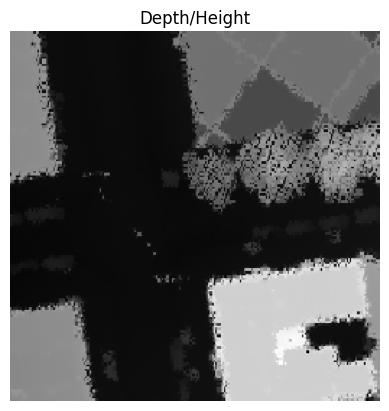

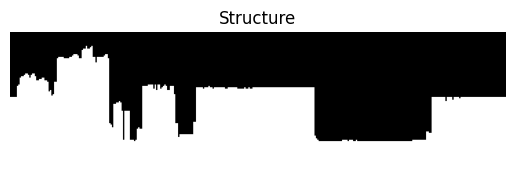

(105, 360)


In [ ]:
def process_depth_image(npz_path):
    depth_image = load_depth_image(npz_path)
    binary_panorama = create_panorama(depth_image)
    return binary_panorama

# Example usage
npz_path = '/content/197180.npz'
height_data = load_depth_image(npz_path)
binary_panorama = create_panorama_poc(height_data, fov=360, rotation=0, height_scale=1.0, sky_space =10)
print(binary_panorama.shape)

img 3

range: 40.682200,-73.911896,40.682721,-73.911209

camera position: 40.682317_-73.911638

## Adding camera coordinates


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def create_panorama(height_data, camera_lat, camera_long, lat_range, long_range, fov=360, rotation=0, height_scale=1.0, sky_space=10, smoothing_sigma=0.5):
    map_height, map_width = height_data.shape
    lat_min, lat_max, long_min, long_max = lat_range[0], lat_range[1], long_range[0], long_range[1]

    # Calculate pixel per degree for latitude and longitude
    pixel_per_lat = map_height / (lat_max - lat_min)
    pixel_per_long = map_width / (long_max - long_min)

    # Convert camera coordinates to pixel indices
    camera_position_x = int((camera_long - long_min) * pixel_per_long)
    camera_position_y = int((lat_max - camera_lat) * pixel_per_lat)
    camera_position = (camera_position_x, camera_position_y)

    output_width = fov  # Each degree in the panorama
    max_height = int(np.max(height_data) * height_scale)
    panorama = np.zeros((max_height + sky_space, output_width), dtype=np.uint8)

    # Normalize height data to grayscale (0-255)
    normalized_heights = (height_data / np.max(height_data) * 255).astype(np.uint8)

    # Array to store max building heights at each angle
    max_building_heights = np.zeros(output_width, dtype=int)

    # Loop over each degree in the panorama (360 degrees)
    for angle in range(output_width):
        adjusted_angle = (angle + rotation) % 360
        radian = np.deg2rad(adjusted_angle)

        max_building_height = 0
        distance = 1
        while True:
            x_offset = int(camera_position[0] + np.cos(radian) * distance)
            y_offset = int(camera_position[1] + np.sin(radian) * distance)

            if not (0 <= x_offset < map_width and 0 <= y_offset < map_height):
                break

            current_height = int(height_data[y_offset, x_offset] * height_scale)
            if current_height > max_building_height:
                max_building_height = current_height

            distance += 1

        # Store the max building height for this angle
        max_building_heights[angle] = max_building_height

    # Smooth the max building heights array
    smoothed_heights = gaussian_filter1d(max_building_heights, sigma=smoothing_sigma)

    # Apply the smoothed heights to the panorama
    for angle in range(output_width):
        smoothed_height = int(smoothed_heights[angle])
        if smoothed_height > 0:
            panorama[:smoothed_height, angle] = 255

    # Display the camera position on the satellite depth image
    plt.imshow(height_data, cmap='gray')
    plt.scatter([camera_position_x], [camera_position_y], color='red', s=100)
    plt.title("Satellite Depth Image with Camera Position")
    plt.axis('off')
    plt.show()

    # Display the smoothed black-and-white panorama
    plt.imshow(panorama, cmap='gray', origin='lower')
    plt.title("Smoothed Structure (w/o distance scaling)")
    plt.axis('off')
    plt.show()

    return panorama

# Example usage:
# height_data = loaded height data array
# camera_lat, camera_long = camera latitude and longitude
# lat_range = (min_latitude, max_latitude)
# long_range = (min_longitude, max_longitude)
# panorama = create_panorama(height_data, camera_lat, camera_long, lat_range, long_range, smoothing_sigma=2)


In [ ]:

# def create_panorama(height_data, camera_lat, camera_long, lat_range, long_range, fov=360, rotation=0, height_scale=1.0, sky_space=10):
#     map_height, map_width = height_data.shape
#     lat_min, lat_max, long_min, long_max = lat_range[0], lat_range[1], long_range[0], long_range[1]

#     # Calculate pixel per degree for latitude and longitude
#     pixel_per_lat = map_height / (lat_max - lat_min)
#     pixel_per_long = map_width / (long_max - long_min)

#     # Convert camera coordinates to pixel indices
#     camera_position_x = int((camera_long - long_min) * pixel_per_long)
#     camera_position_y = int((lat_max - camera_lat) * pixel_per_lat)  # Note lat_max because array indexing is top to bottom
#     camera_position = (camera_position_x, camera_position_y)

#     output_width = fov  # Each degree in the panorama
#     max_height = int(np.max(height_data) * height_scale)
#     panorama = np.zeros((max_height + sky_space, output_width), dtype=np.uint8)  # Black-and-white panorama

#     # Normalize height data to grayscale (0-255)
#     normalized_heights = (height_data / np.max(height_data) * 255).astype(np.uint8)

#     # Loop over each degree in the panorama (360 degrees)
#     for angle in range(output_width):
#         adjusted_angle = (angle + rotation) % 360
#         radian = np.deg2rad(adjusted_angle)

#         max_building_height = 0
#         distance = 1
#         while True:
#             x_offset = int(camera_position[0] + np.cos(radian) * distance)
#             y_offset = int(camera_position[1] + np.sin(radian) * distance)

#             if not (0 <= x_offset < map_width and 0 <= y_offset < map_height):
#                 break

#             current_height = int(height_data[y_offset, x_offset] * height_scale)
#             if current_height > max_building_height:
#                 max_building_height = current_height

#             distance += 1

#         if max_building_height > 0:
#             panorama[:max_building_height, angle] = 255

#     # Display the camera position on the satellite depth image
#     plt.imshow(height_data, cmap='gray')
#     plt.scatter([camera_position_x], [camera_position_y], color='red', s=100)  # Mark the camera position
#     plt.title("Satellite Depth Image with Camera Position")
#     plt.axis('off')
#     plt.show()

#     # Display or save the black-and-white panorama
#     plt.imshow(panorama, cmap='gray', origin='lower')
#     plt.title("Structure")
#     plt.axis('off')
#     plt.show()
#     return panorama

# # Example usage:
# # height_data = loaded height data array
# # camera_lat, camera_long = camera latitude and longitude
# # lat_range = (min_latitude, max_latitude)
# # long_range = (min_longitude, max_longitude)
# # panorama = create_panorama(height_data, camera_lat, camera_long, lat_range, long_range)

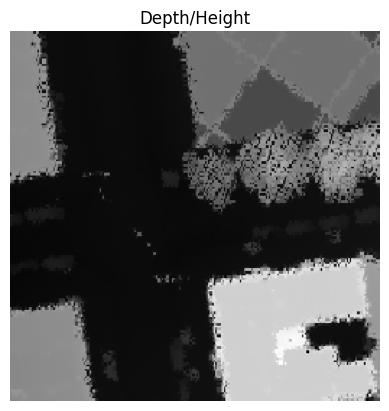

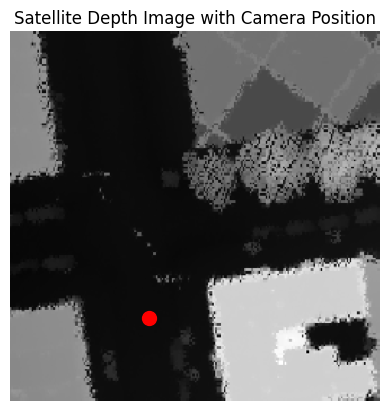

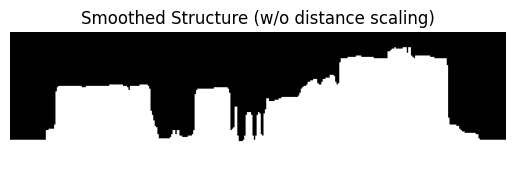

(105, 360)


In [ ]:
# Example usage
npz_path = '/content/197180.npz'
height_data = load_depth_image(npz_path)
binary_panorama = create_panorama(height_data, 40.682317, -73.911638, (40.682200,40.682721), (-73.911896,-73.911209), fov=360, rotation=90, height_scale=1.0, sky_space =10)
print(binary_panorama.shape)

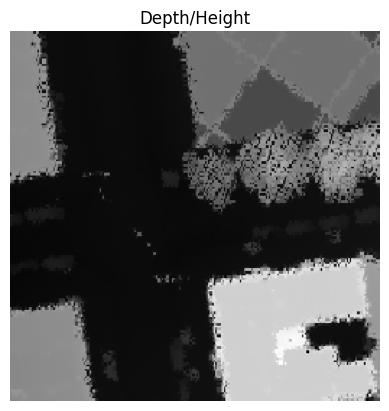

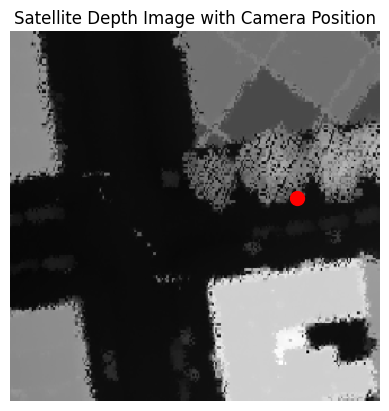

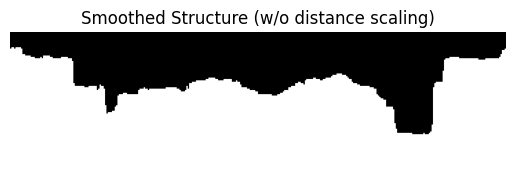

(105, 360)


In [ ]:
# Example usage
npz_path = '/content/197180.npz'
height_data = load_depth_image(npz_path)
binary_panorama = create_panorama(height_data, 40.682485, -73.911364, (40.682200,40.682721), (-73.911896,-73.911209), fov=360, rotation=90, height_scale=1.0, sky_space =10)
print(binary_panorama.shape)

## Scale height based on distance

In [ ]:

def create_scaled_panorama(height_data, camera_lat, camera_long, lat_range, long_range, fov=360, rotation=0, height_scale=1.0, sky_space=10, distance_decay=0.01, smoothing_sigma=0.5):
    map_height, map_width = height_data.shape
    lat_min, lat_max, long_min, long_max = lat_range[0], lat_range[1], long_range[0], long_range[1]

    # Calculate pixel per degree for latitude and longitude
    pixel_per_lat = map_height / (lat_max - lat_min)
    pixel_per_long = map_width / (long_max - long_min)

    # Convert camera coordinates to pixel indices
    camera_position_x = int((camera_long - long_min) * pixel_per_long)
    camera_position_y = int((lat_max - camera_lat) * pixel_per_lat)
    camera_position = (camera_position_x, camera_position_y)

    output_width = fov  # Each degree in the panorama
    max_height = int(np.max(height_data) * height_scale)
    panorama = np.zeros((max_height + sky_space, output_width), dtype=np.uint8)

    # Array to store max building heights at each angle
    max_building_heights = np.zeros(output_width, dtype=int)

    # Loop over each degree in the panorama (360 degrees)
    for angle in range(output_width):
        adjusted_angle = (angle + rotation) % 360
        radian = np.deg2rad(adjusted_angle)

        max_building_height = 0
        distance = 1
        while True:
            x_offset = int(camera_position[0] + np.cos(radian) * distance)
            y_offset = int(camera_position[1] + np.sin(radian) * distance)

            if not (0 <= x_offset < map_width and 0 <= y_offset < map_height):
                break

            # Apply a perspective scale based on distance
            perspective_scale = 1 / (1 + distance_decay * distance)
            current_height = int(height_data[y_offset, x_offset] * height_scale * perspective_scale)
            if current_height > max_building_height:
                max_building_height = current_height

            distance += 1

        # Store the max building height for this angle
        max_building_heights[angle] = max_building_height

    # Smooth the max building heights array
    smoothed_heights = gaussian_filter1d(max_building_heights, sigma=smoothing_sigma)

    # Apply the smoothed heights to the panorama
    for angle in range(output_width):
        smoothed_height = int(smoothed_heights[angle])
        if smoothed_height > 0:
            panorama[:smoothed_height, angle] = 255

    # Display the camera position on the satellite depth image
    plt.imshow(height_data, cmap='gray')
    plt.scatter([camera_position_x], [camera_position_y], color='red', s=100)
    plt.title("Satellite Depth Image with Camera Position")
    plt.axis('off')
    plt.show()

    # Display the smoothed black-and-white panorama
    plt.figure(figsize=(10, 2))
    plt.imshow(panorama, cmap='gray', origin='lower')
    plt.title("Structure with distance scaling and smoothed heights")
    plt.axis('off')
    plt.show()

    return panorama

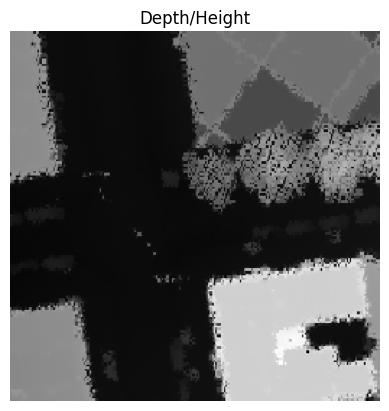

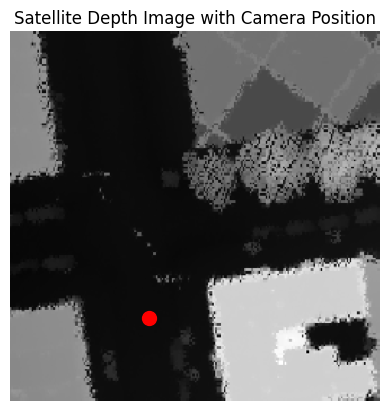

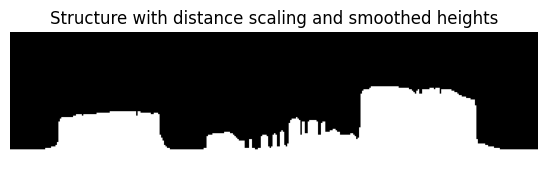

(105, 360)


In [ ]:
# decay = 0.006
npz_path = '/content/197180.npz'
height_data = load_depth_image(npz_path)
binary_panorama2 = create_scaled_panorama(height_data, 40.682317, -73.911638, (40.682200,40.682721), (-73.911896,-73.911209), fov=360, rotation=90, height_scale=1.0, sky_space =10, distance_decay = 0.006)
print(binary_panorama.shape)

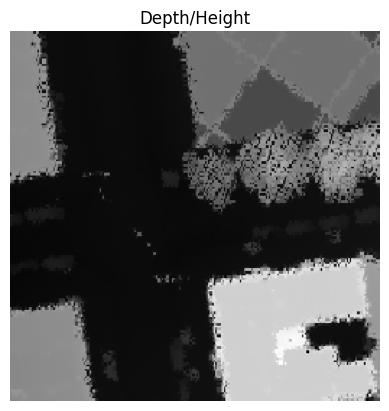

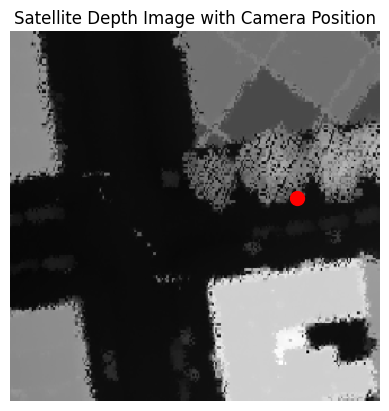

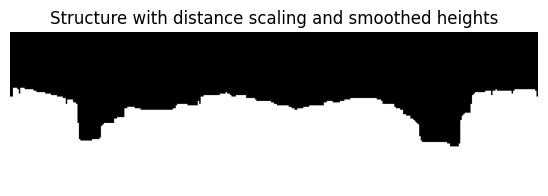

(105, 360)


In [ ]:
npz_path = '/content/197180.npz'
height_data = load_depth_image(npz_path)
binary_panorama2 = create_scaled_panorama(height_data, 40.682485, -73.911364, (40.682200,40.682721), (-73.911896,-73.911209), fov=360, rotation=90, height_scale=1.0, sky_space =10, distance_decay = 0.006)
print(binary_panorama.shape)

## Adjust dimensions to the same as streetviews

streetview panorama dimension is (1664, 3328, 3)

In [ ]:
# pano1_path = '/content/40.712474_-73.940945.jpg'
# pano2_path = '/content/40.712646_-73.941241.jpg'
pano3_path = '/content/40.682485_-73.911364.jpg'
img = Image.open(pano3_path)
# display(img)
img_np = np.array(img)
print(img_np.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/40.682485_-73.911364.jpg'

In [ ]:
def scale_output(input_panorama, target_height=1664, target_width=3328):
     # Convert the input numpy array to a PIL Image
    image = Image.fromarray(input_panorama)

    # Resize the image to the specified dimensions using the LANCZOS resampling algorithm
    resized_image = image.resize((target_width, target_height), Image.Resampling.LANCZOS)

    # Convert the PIL Image back to a numpy array if needed
    output_panorama = np.array(resized_image)

    return output_panorama

(1664, 3328)


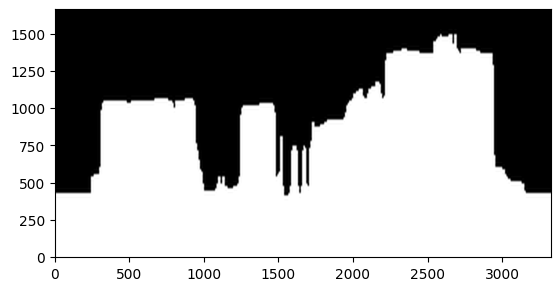

In [ ]:
# output without distance scaling
output1 = scale_output(binary_panorama)
plt.imshow(output1, cmap='gray', origin='lower')
print(output1.shape)

(1664, 3328)


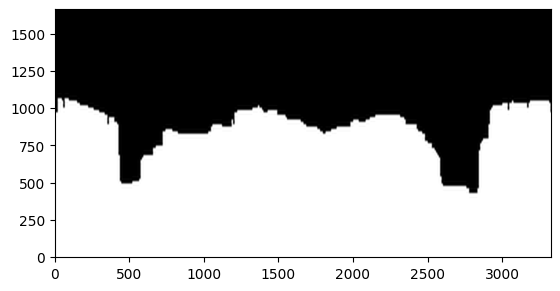

In [ ]:
# with distance scaling
output2 = scale_output(binary_panorama2)
plt.imshow(output2, cmap='gray', origin='lower')
print(output2.shape)